In [5]:
import sys
sys.path.append("../../")

from transportnet import net
from transportnet import line
from transportnet import vehicle
from stochastic import stochastic

from genetics import ga

import folium
from leafmap import foliumap as leafmap

from matplotlib import pyplot as plt
from scipy import stats as ss
import numpy as np

In [7]:
n = net.Net()

n.load_nodes_from_file('verkhnodniprovsk_nodes.txt')
# define the network configuration
n.load_from_file('verkhnodniprovsk_edges.txt')

# define demand intensity
for nd in n.nodes:
    nd.s_interval = stochastic.Stochastic(law=2, scale=30)
central = n.get_node(code=1)
central.s_interval = stochastic.Stochastic(law=2, scale=5)

# define a set of public transport lines
line1 = line.Line(n, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                    13, 12, 11, 15, 16, 17, 18, 19, 1], 
                    [1, 14])
line1.same_back_direction = False
line1.color = 'red'
line1.add_vehicles([vehicle.Vehicle(18)])

line2 = line.Line(n, [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1],
                    [1, 1])
line2.same_back_direction = False
line2.color = 'green'
line2.add_vehicles([vehicle.Vehicle(50)])
line3 = line.Line(n, [1, 20, 33, 34, 35, 36, 37, 38,
                    37, 39, 36, 35, 18, 19, 1],
                    [1, 38])
line3.same_back_direction = False
line3.color = 'brown'
line3.add_vehicles([vehicle.Vehicle(18)])
line4 = line.Line(n, [1, 3, 4, 40, 41, 42, 43, 44,
                    43, 42, 41, 40, 4, 3, 1],
                    [1, 44])
line4.same_back_direction = True
line4.color = 'blue'
line4.add_vehicles([vehicle.Vehicle(38)])
line5 = line.Line(n, [1, 3, 4, 40, 41, 42, 45, 46, 47,
                    46, 45, 42, 41, 40, 4, 3, 1],
                    [1, 47])
line5.same_back_direction = True
line5.color = 'grey'
line5.add_vehicles([vehicle.Vehicle(38)])

n.lines.extend([line1, line2, line3, line4, line5])

mean_lat, mean_lon = 0, 0
for nd in n.nodes:
    mean_lat += nd.latitude
    mean_lon += nd.longitude
mean_lat /= len(n.nodes)
mean_lon /= len(n.nodes)

## All routes

In [8]:
m = leafmap.Map(
    location=[mean_lat, mean_lon],
    tiles="OpenStreetMap",
    zoom_start=12
)

ln = n.lines[2]

for idx in range(len(ln.nodes)):
    nd = ln.nodes[idx]    
    if idx > 0:
        pnd = ln.nodes[idx - 1]
        lnk = n.get_link(pnd, nd)
        # print(lnk, lnk.weight, lnk.track)
        # print([(pnd.latitude, pnd.longitude)] + lnk.track + [(nd.latitude, nd.longitude)])
        folium.PolyLine([(pnd.latitude, pnd.longitude)] + lnk.track + [(nd.latitude, nd.longitude)],
                    color=ln.color,
                    weight=4,
                    opacity=0.5).add_to(m)
    
    folium.CircleMarker(
        location=[nd.latitude, nd.longitude],
        popup=nd.name,
        radius = 5,
        fill=True,
        fill_color=ln.color,
        color=ln.color,
        fill_opacity=0.5
    ).add_to(m)

m

In [3]:
m = leafmap.Map(
    location=[mean_lat, mean_lon],
    tiles="OpenStreetMap",
    # width=500, height=500,
    zoom_start=12
)

# legend_dict = {
#     'Маршрут 1': 'red',
#     'Маршрут 2': 'green',
#     'Маршрут 3': 'brown',
#     'Маршрут 4': 'blue',
#     'Маршрут 5': 'grey'
# }
legend_dict = {
    'Line #1': 'red',
    'Line #2': 'green',
    'Line #3': 'brown',
    'Line #4': 'blue',
    'Line #5': 'grey'
}

# m.add_legend(legend_dict=legend_dict, title='Позначення')
m.add_legend(legend_dict=legend_dict, title='Legend')

for ln in n.lines:

    for idx in range(len(ln.nodes)):
        nd = ln.nodes[idx]
        
        # folium.Marker(
        #     icon=folium.Icon(color='green', prefix='fa', icon='bus', size=3),
        #     location=[nd.latitude, nd.longitude],
        #     popup=nd.name
        # ).add_to(m)
        
        if idx > 0:
            pnd = ln.nodes[idx - 1]
            lnk = n.get_link(pnd, nd)
            # print(lnk, lnk.weight, lnk.track)
            # print([(pnd.latitude, pnd.longitude)] + lnk.track + [(nd.latitude, nd.longitude)])
            folium.PolyLine([(pnd.latitude, pnd.longitude)] + lnk.track + [(nd.latitude, nd.longitude)],
                        color=ln.color,
                        weight=4,
                        opacity=0.5).add_to(m)
        
        folium.CircleMarker(
            location=[nd.latitude, nd.longitude],
            popup=nd.name,
            radius = 5,
            fill=True,
            fill_color=ln.color,
            color=ln.color,
            fill_opacity=0.5
        ).add_to(m)

m

## Transfer nodes

In [4]:
m = leafmap.Map(
    location=[mean_lat, mean_lon],
    tiles="OpenStreetMap",
    # width=500, height=500,
    zoom_start=12
)

# legend_dict = {
#     'Зупинка': 'grey',
#     'Пересадочний вузол': 'orange'
# }
legend_dict = {
    'Public transport stop': 'grey',
    'Transfer node': 'orange'
}

# m.add_legend(legend_dict=legend_dict, title='Позначення')
m.add_legend(legend_dict=legend_dict, title='Legend')

for ln in n.lines:
    for idx in range(len(ln.nodes)):
        nd = ln.nodes[idx]     
        if idx > 0:
            pnd = ln.nodes[idx - 1]
            lnk = n.get_link(pnd, nd)
            folium.PolyLine([(pnd.latitude, pnd.longitude)] + lnk.track + [(nd.latitude, nd.longitude)],
                        color='grey',
                        weight=4,
                        opacity=0.5).add_to(m)
            
for nd in n.nodes:
    color = 'orange' if nd in n.transfer_nodes else 'grey'
    folium.CircleMarker(
        location=[nd.latitude, nd.longitude],
        popup=nd.name,
        radius = 5 if nd in n.transfer_nodes else 3,
        fill=True,
        fill_color=color,
        color=color,
        fill_opacity = 1 if nd in n.transfer_nodes else 0.5
    ).add_to(m)
m

## Simulate net

In [14]:
sim_time = 2.0 * 60
n.duration = sim_time
model_runs = 300

def fitness_function(shifts):
    res = []
    for _ in range(model_runs):
        n.reset()
        for idx in range(len(n.lines)):
            n.lines[idx].schedule_shift = shifts[idx]
        n.gen_demand(duration=n.duration)
        x = n.simulate(sim_time)
        res.append(x)
    return np.array(res)

res0 = fitness_function([0, 0, 0, 0, 0])
res = fitness_function([75, 90, 30, 95, 0])
# nss = len([p for p in n.demand if p.service_started])
# nsf = len([p for p in n.demand if p.service_finished])
# print(res, len(n.demand), nss, nsf)
res0.mean(), res.mean()

(42.456771128719005, 49.151312916265304)

(49.151312916265304, 2.3319248482588875)


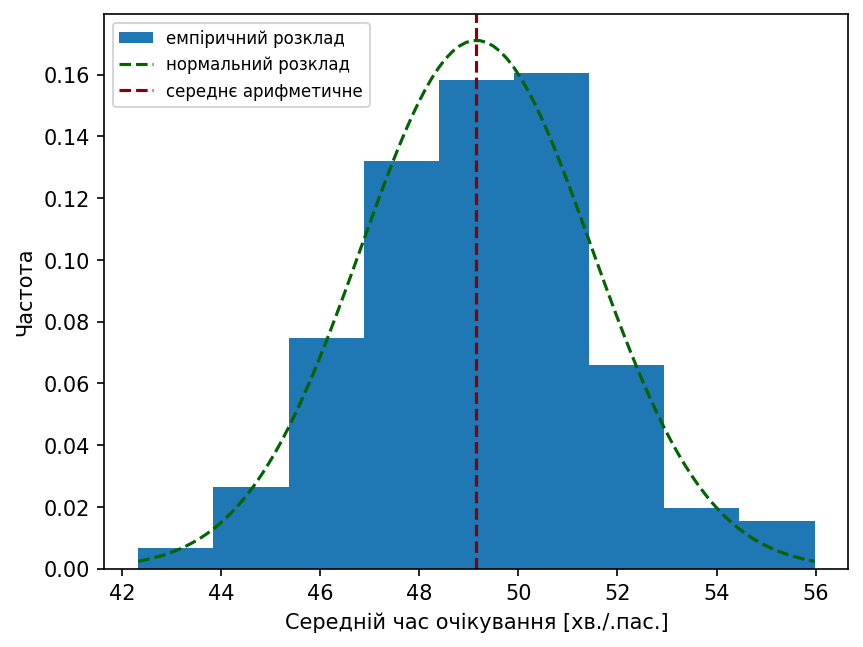

In [15]:
def plot_hist(res):
    xs = np.linspace(min(res), max(res), 100)
    params = ss.norm.fit(res)
    print(params)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(res, bins=9, density=True,
             label='емпіричний розклад')
    plt.plot(xs, ss.norm.pdf(xs, *params), linestyle='--', color='darkgreen',
             label='нормальний розклад')
    plt.axvline(res.mean(), linestyle='--', color='darkred',
                label='середнє арифметичне')
    plt.xlabel('Середній час очікування [хв./.пас.]')
    plt.ylabel('Частота')
    plt.legend(fontsize=8)
    plt.show()

plot_hist(res)

(42.456771128719005, 2.039741938855383)


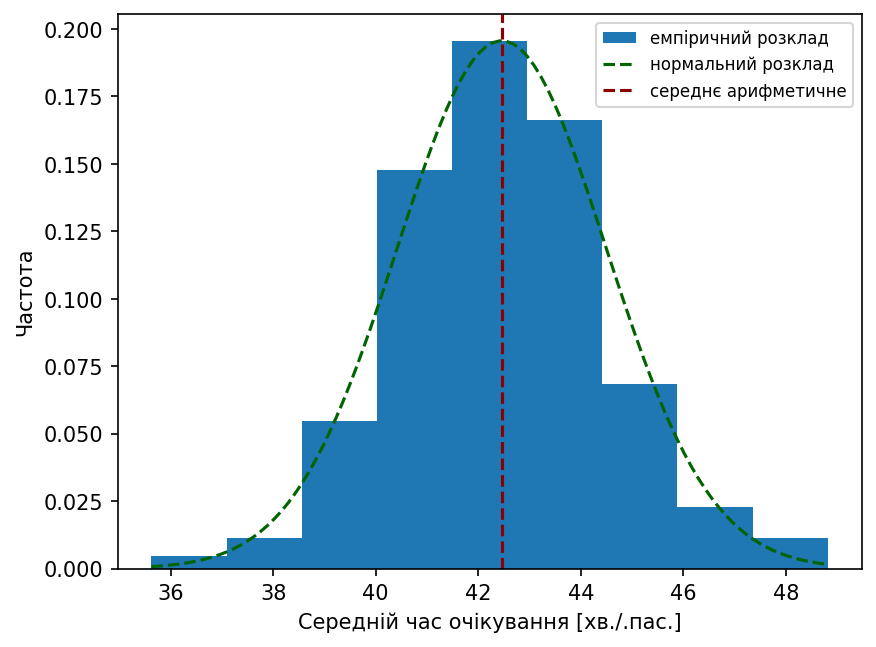

In [16]:
plot_hist(res0)

In [17]:
def needed(xs, alpha=0.05):
    mean = xs.mean()
    var = xs.var()
    u_alpha = ss.norm.ppf(1 - alpha)
    return var * u_alpha**2 / (alpha * mean)**2

needed(res)

2.4359779850107888

In [9]:
for ln in n.lines:
    print(ln.turnaround_time, ln.net.duration, ln.turns_number, len(ln.vehicles),
          [nd.code for nd in ln.nodes_sequence]
    )

56.8 120.0 3 1 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 13, 12, 11, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 13, 12, 11, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 13, 12, 11, 15, 16, 17, 18, 19, 1]
48.416 120.0 3 1 [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1]
47.36 120.0 3 1 [1, 20, 33, 34, 35, 36, 37, 38, 37, 39, 36, 35, 18, 19, 1, 20, 33, 34, 35, 36, 37, 38, 37, 39, 36, 35, 18, 19, 1, 20, 33, 34, 35, 36, 37, 38, 37, 39, 36, 35, 18, 19, 1]
87.08 120.0 2 1 [1, 3, 4, 40, 41, 42, 43, 44, 43, 42, 41, 40, 4, 3, 1, 3, 4, 40, 41, 42, 43, 44, 43, 42, 41, 40, 4, 3, 1, 3, 4, 40, 41, 42, 43, 44, 43, 42, 41, 40, 4, 3, 1, 3, 4, 40, 41, 42, 43, 44, 43, 42, 41, 40, 4, 3, 1]
81.49599999999998 120.0 2 1 [1, 3, 4, 40, 41, 42, 45, 46, 47, 46, 45, 42, 41, 40, 4, 3, 1, 3, 4, 40, 41, 42, 45, 

In [10]:
ps = [p for p in n.demand if p.service_finished]
# ps = [p for p in n.demand if p.service_started]
# ps = [p for p in n.demand if not p.service_started]
wt = 0
for pas in sorted(ps, key=lambda p: p.m_appearance):
    wt += pas.wait_time
    print(pas.m_appearance,
          pas.m_boarding, pas.m_disembarkation,
          pas.travel_time, pas.ride_time, pas.wait_time,
          pas.travel_to_be_finished, len(pas.used_vehicles),
          f'{pas.origin_node.code}->{[nd.code for nd in pas.destination_nodes]}({pas.current_destination_node.code})'
        )
len(ps), wt / len(ps)

1.6 [34, 50] [44, 61] 59.4 21 38.4 True 2 36->[1, 5](5)
3.8000000000000003 [13] [20] 16.2 7 9.2 True 1 36->[38](38)
4.7 [37] [79] 74.3 42 32.3 True 1 44->[1](1)
5.2 [38, 85] [50, 96] 90.8 23 67.8 True 2 15->[1, 22](22)
5.6 [66, 85] [75, 98] 92.4 22 70.4 True 2 40->[1, 23](23)
5.800000000000001 [31, 75] [44, 115] 109.2 53 56.2 True 2 39->[1, 47](47)
6.6 [8] [30] 23.4 22 1.4000000000000004 True 1 23->[31](31)
8.2 [42, 85] [75, 109] 100.8 57 43.8 True 2 46->[1, 28](28)
11.7 [50, 85] [75, 115] 103.3 55 48.3 True 2 42->[1, 30](30)
14.2 [50] [73] 58.8 23 35.8 True 1 1->[11](11)
14.5 [28] [34] 19.5 6 13.5 True 1 37->[36](36)
18.5 [50, 93] [75, 105] 86.5 37 49.5 True 2 42->[1, 34](34)
18.8 [35, 85] [75, 100] 81.2 55 26.2 True 2 47->[1, 24](24)
19.0 [66, 85] [75, 120] 101.0 44 57.0 True 2 40->[1, 31](31)
19.7 [31] [40] 20.3 9 11.3 True 1 13->[16](16)
20.4 [32, 40] [34, 43] 22.6 5 17.6 True 2 32->[16, 17](17)
21.2 [62] [71] 49.8 9 40.8 True 1 41->[4](4)
23.8 [50, 85] [75, 107] 83.2 47 36.2 True 

(55, 30.945454545454552)

In [9]:
schedules = [[75, 90, 30, 95, 0]]

# for schedule in schedules:
#     print(schedule)
#     res_file = open(f'./net_results/{schedule}.txt', 'w')
#     for _ in range(model_runs):
#         res_str = ''
#         for res in fitness_function(schedule):
#             res_str += str(res) + '\t'
#         res_str = res_str[:-1]
#         res_file.write(res_str + '\n')
#         print(res_str)
#     print()
#     res_file.close()

## Run GA

In [ ]:
winners = []
for iter in range(30):
    print(iter + 1)
    g = ga.GA()
    g.chromosome_size = len(n.lines), 7
    g.population_size = 100
    g.generations = 20
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = fitness_function
    winner = g.run()
    winners.append(winner[1])
    print()

1
winner #1 ([17, 32, 28, 51, 37], (39.13272727272727, <genetics.chromosome.Chromosome object at 0x16b642140>))
winner #2 ([17, 32, 28, 35, 37], (40.39783783783782, <genetics.chromosome.Chromosome object at 0x16b7c22c0>))
winner #3 ([17, 32, 28, 35, 37], (37.43414634146342, <genetics.chromosome.Chromosome object at 0x16b7c22c0>))
winner #4 ([22, 8, 19, 58, 12], (36.40981308411215, <genetics.chromosome.Chromosome object at 0x16b7c21d0>))
winner #5 ([25, 12, 19, 39, 2], (37.107614213197955, <genetics.chromosome.Chromosome object at 0x16b7ba3b0>))
winner #6 ([16, 40, 24, 18, 10], (37.461274509803914, <genetics.chromosome.Chromosome object at 0x16b7c19f0>))
winner #7 ([22, 9, 19, 58, 12], (36.8289340101523, <genetics.chromosome.Chromosome object at 0x16b92e560>))
winner #8 ([34, 4, 11, 55, 12], (38.5425, <genetics.chromosome.Chromosome object at 0x16b7b9ae0>))
winner #9 ([18, 8, 2, 41, 2], (36.95227272727275, <genetics.chromosome.Chromosome object at 0x16b941cf0>))
winner #10 ([16, 9, 19, 

In [52]:
np.array(winners).tofile('net30x20.txt', sep=',', format='%s')

## Analyze results

In [10]:
xs = np.fromfile('net_results/net30x20.txt', sep=',').reshape((30, 20))

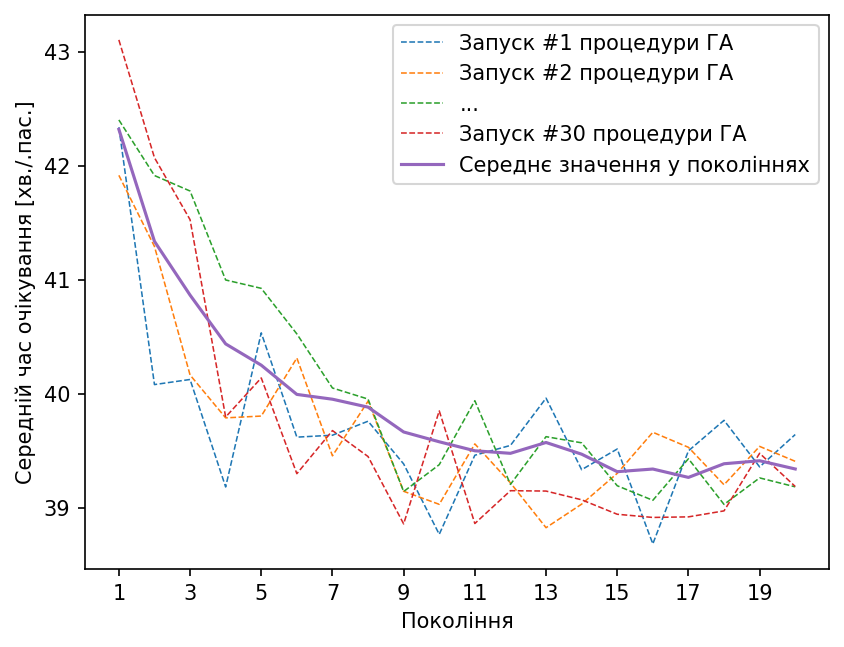

In [12]:
plt.figure(dpi=150)
plt.plot(range(1, 21), xs[9], lw=0.75, label=f'Запуск #1 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[10], lw=0.75, label=f'Запуск #2 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[11], lw=0.75, label=f'...', linestyle='--')
plt.plot(range(1, 21), xs[28], lw=0.75, label=f'Запуск #30 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Покоління')
plt.xticks(range(1,21, 2))
plt.legend()
plt.show()

In [18]:
# [22, 12, 0, 41, 5] 34.72969432314411
# [28, 10, 27, 11, 42] 34.485507246376805
# [24, 1, 5, 44, 8] 34.05520833333333 -> 41.28601271048156
# [21, 48, 11, 5, 40] 34.97326732673267
# [38, 12, 31, 10, 48] 34.59777777777778
# [24, 6, 32, 7, 57] 34.824271844660196
# [12, 1, 16, 35, 9] 34.26974358974359
# [22, 43, 2, 21, 5] 34.150837988826815
# [30, 5, 2, 37, 11] 34.4970731707317 -> 41.44686527630496
# [1, 5, 3, 16, 10] 34.31759259259257 -> 42.151973123420596

# [22, 9, 38, 42, 8] 39.03654603860084
# [23, 2, 3, 22, 5] 38.58572561534168
# [20, 2, 28, 41, 4] 38.95112672304971

model_runs = 300

schedules = [
    [22, 12, 0, 41, 5],
    [28, 10, 27, 11, 42],
    [24, 1, 5, 44, 8],
    [21, 48, 11, 5, 40],
    [38, 12, 31, 10, 48],
    [24, 6, 32, 7, 57],
    [12, 1, 16, 35, 9],
    [22, 43, 2, 21, 5],
    [30, 5, 2, 37, 11],
    [1, 5, 3, 16, 10]
]

# schedules = [
#     [22, 9, 38, 42, 8],
#     [23, 2, 3, 22, 5],
#     [20, 2, 28, 41, 4]
# ]

bests = [
    fitness_function(schedule)
    for schedule in schedules
]

# bests_SP = [
#     fitness_function(schedule)
#     for schedule in schedules
# ]

In [19]:
# base shifted to 6:30 [20, 0, 0, 5, 14]
res_base = fitness_function([20, 0, 0, 5, 14])

In [20]:
res_base.mean()

42.06029306804274

In [43]:
# [22, 12, 0, 41, 5] 42.357528997212015
# [28, 10, 27, 11, 42] 42.25762323136005
# [24, 1, 5, 44, 8] 41.05252375255695
# [21, 48, 11, 5, 40] 42.450130700919495
# [38, 12, 31, 10, 48] 42.28001330666937
# [24, 6, 32, 7, 57] 42.229303642852344
# [12, 1, 16, 35, 9] 41.524866366149254
# [22, 43, 2, 21, 5] 41.93171752132541
# [30, 5, 2, 37, 11] 41.617996172115724
# [1, 5, 3, 16, 10] 42.095181133952536

In [21]:
for idx in range(len(schedules)):
    print(idx, schedules[idx], bests[idx].mean())

0 [22, 12, 0, 41, 5] 42.03233935182601
1 [28, 10, 27, 11, 42] 42.3079493162361
2 [24, 1, 5, 44, 8] 40.958940996665575
3 [21, 48, 11, 5, 40] 42.42141988872675
4 [38, 12, 31, 10, 48] 42.60227248802133
5 [24, 6, 32, 7, 57] 42.370453914962965
6 [12, 1, 16, 35, 9] 41.648682732297225
7 [22, 43, 2, 21, 5] 41.94797403589715
8 [30, 5, 2, 37, 11] 41.69982707769222
9 [1, 5, 3, 16, 10] 42.18393081844676


(49.151312916265304, 2.3319248482588875) (40.958940996665575, 2.126014646567909)


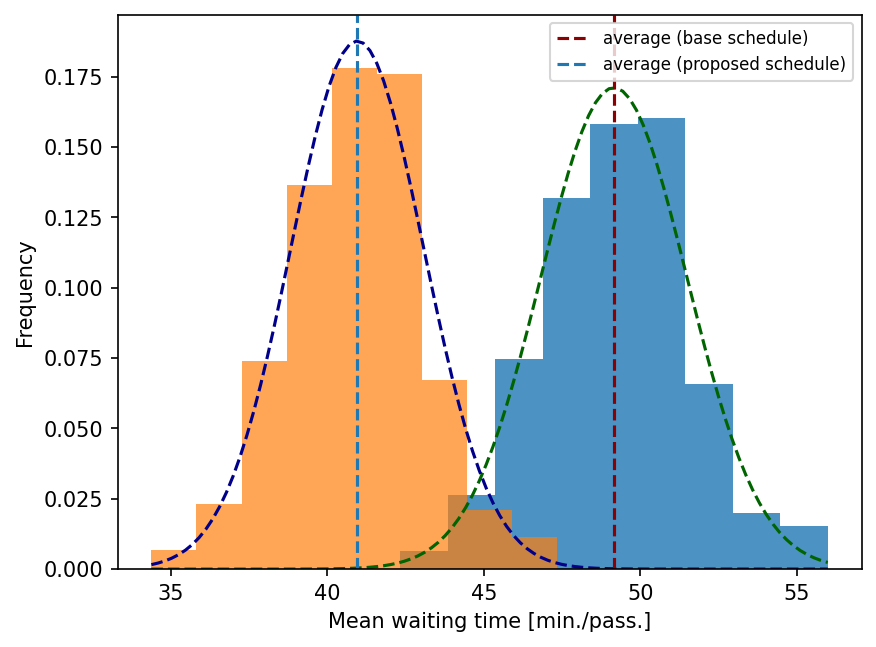

In [28]:
def plot_hist2(res1, res2):
    xs = np.linspace(min(res1.min(), res2.min()),
                     max(res1.max(), res2.max()), 100)
    params1, params2 = ss.norm.fit(res1), ss.norm.fit(res2)
    print(params1, params2)
    fig = plt.figure(dpi=150)
    # ax = fig.add_subplot(1, 1, 1)
    plt.hist(res1, density=True, bins=9, alpha=0.8
            #  label='емпіричний розклад (базовий)'
             )
    plt.hist(res2, density=True, bins=9, alpha=0.7
            #  label='емпіричний розклад (пропонований)'
             )
    plt.plot(xs, ss.norm.pdf(xs, *params1), linestyle='--', color='darkgreen',
            #  label='нормальний розклад (базовий)'
             )
    plt.plot(xs, ss.norm.pdf(xs, *params2), linestyle='--', color='darkblue',
            #  label='нормальний розклад (пропонований)'
             )
    
    plt.axvline(res1.mean(), linestyle='--', color='darkred',
                label='average (base schedule)')
                # label='середнє (базовий розклад)')
    plt.axvline(res2.mean(), linestyle='--', #color='orange',
                # label='середнє (пропонований розклад)')
                label='average (proposed schedule)')

    plt.xlabel('Середній час очікування [хв./пас.]')
    plt.ylabel('Частота')
    
    plt.xlabel('Mean waiting time [min./pass.]')
    plt.ylabel('Frequency')
    plt.legend(fontsize=8, loc='upper right')
    plt.show()

plot_hist2(res, bests[2])

In [13]:
t0, t1 = res.mean(), bests[2].mean()
(t0 - t1) / t0 * 100

15.69958652940923